# Building the model

In [1]:
import os
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import preproc

In [2]:
N_EPOCHS = 200
BATCH_SIZE = 64

cols = ['latitude', 'longitude', 'timestamp']

## Load the dataset

In [3]:
data_dir = 'dataset/reduced_preprocessed'
train = np.load(os.path.join(data_dir, 'train.npy'))
valid = np.load(os.path.join(data_dir, 'valid.npy'))
test = np.load(os.path.join(data_dir, 'test.npy'))

bounds = {}
bounds_path = os.path.join(data_dir, 'bounds.json')
with open(bounds_path) as file:
    bounds = json.load(file)

# Create the model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

event_vec_dim = train.shape[-1]
seq_len = preproc.WINDOW_SIZE
hidden_dim = 1024
num_layers = 4

In [5]:
from lstm_model import FirePredictor

# create the model
model = FirePredictor(event_vec_dim, seq_len, hidden_dim, num_layers)

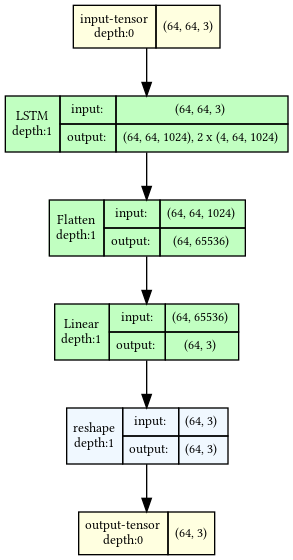

In [6]:
# visualize model structure
# This uses torchview, which is a library outside of pytorch for visualizing torch.nn.Modules
# https://github.com/mert-kurttutan/torchview
import graphviz
graphviz.set_jupyter_format('png')

from torchview import draw_graph
model_graph = draw_graph(model, input_size=(BATCH_SIZE, seq_len, event_vec_dim), device='cuda')
model_graph.visual_graph

## Write the loss function

In [7]:
# def euclidean_dist(t1, t2, dim):
#     return (t1 - t2).pow(2).sum(dim).sqrt()
#
# def avg_distance(x, y):
#     if x.isnan().any():
#         print(x)
#         raise RuntimeError("Loss func: x contains NAN")
#     # use nearest neighbor upsampling
#     reshaped = torch.nn.functional.interpolate(x[:,:,None,:], size=y.shape[2:], mode='nearest')
#     if reshaped.isnan().any():
#         print(reshaped)
#         raise RuntimeError("Loss func: reshaped x contains NAN")
#     result = (euclidean_dist(reshaped, y, dim=2)).sum() / np.array(y.shape[0:-1]).prod()
#     if result.isnan().any():
#         print(result)
#         raise RuntimeError("Loss func: result contains NAN")
#     return result
#
#
# x = torch.Tensor(sequences[0:3,0:64,0,:])
# y = torch.Tensor(sequences[0:3,0:64,1:,:])
#
# print(avg_distance(torch.Tensor(x), torch.Tensor(y)))
# print(f'{x.shape=}, {y.shape=}')

## Prepare Optimizer, Scheduler, and Data Loader

In [8]:
# split train & validation data into inputs and labels
x_train = torch.Tensor(train[:,:64,:])
y_train = torch.Tensor(train[:,64,:])

x_valid = torch.Tensor(valid[:,:64,:]).to(device)
y_valid = torch.Tensor(valid[:,64,:]).to(device)

In [9]:
print(f'{x_valid.shape=}, {y_valid.shape}')

x_valid.shape=torch.Size([161, 64, 3]), torch.Size([161, 3])


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

loss_function = nn.MSELoss()

/home/cynthia/.local/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/cynthia/.local/lib/python3.10/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


## Training Loop

In [11]:
losses_valid = np.zeros(N_EPOCHS)
losses_train = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    # loop over batches
    acc_train_loss = 0.0
    for i, data in enumerate(data_loader):

        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        preds = model(x_batch)

        loss = loss_function(preds, y_batch)
        acc_train_loss += loss
        loss.backward()

        optimizer.step()

    # record average loss of all batches in this epoch
    losses_train[epoch] = acc_train_loss / (x_train.shape[0]/BATCH_SIZE)

    # compute validation loss
    model.eval()
    with torch.no_grad():
        v_preds = model(x_valid)
        losses_valid[epoch] = loss_function(v_preds, y_valid).item()
    model.train()

    # print out the losses so we can see it update as we train
    print(f'Epoch {epoch} -- train loss: {losses_train[epoch]} valid loss: {losses_valid[epoch]}')

Epoch 0 -- train loss: 0.11945189535617828 valid loss: 0.11207503825426102
Epoch 1 -- train loss: 0.08138403296470642 valid loss: 0.09768971055746078
Epoch 2 -- train loss: 0.06601496785879135 valid loss: 0.11768976598978043
Epoch 3 -- train loss: 0.06449372321367264 valid loss: 0.09805255383253098
Epoch 4 -- train loss: 0.0625837966799736 valid loss: 0.10779018700122833
Epoch 5 -- train loss: 0.061500292271375656 valid loss: 0.10215017199516296
Epoch 6 -- train loss: 0.059922777116298676 valid loss: 0.10186078399419785
Epoch 7 -- train loss: 0.05926113575696945 valid loss: 0.10455071926116943
Epoch 8 -- train loss: 0.05982347950339317 valid loss: 0.09958168864250183
Epoch 9 -- train loss: 0.05946763977408409 valid loss: 0.1036127582192421
Epoch 10 -- train loss: 0.05942302197217941 valid loss: 0.10194212198257446
Epoch 11 -- train loss: 0.058579668402671814 valid loss: 0.10221343487501144
Epoch 12 -- train loss: 0.05981261283159256 valid loss: 0.1046682670712471
Epoch 13 -- train loss

Epoch 108 -- train loss: 0.044448383152484894 valid loss: 0.0661291629076004
Epoch 109 -- train loss: 0.04365561529994011 valid loss: 0.061007626354694366
Epoch 110 -- train loss: 0.04368139058351517 valid loss: 0.06558514386415482
Epoch 111 -- train loss: 0.04414960369467735 valid loss: 0.06537987291812897
Epoch 112 -- train loss: 0.04351875185966492 valid loss: 0.06114978343248367
Epoch 113 -- train loss: 0.043447431176900864 valid loss: 0.05957583710551262
Epoch 114 -- train loss: 0.04270394518971443 valid loss: 0.05846363306045532
Epoch 115 -- train loss: 0.042840443551540375 valid loss: 0.0696425661444664
Epoch 116 -- train loss: 0.042609356343746185 valid loss: 0.06047622859477997
Epoch 117 -- train loss: 0.042657818645238876 valid loss: 0.05980053171515465
Epoch 118 -- train loss: 0.041338205337524414 valid loss: 0.05319613590836525
Epoch 119 -- train loss: 0.04178684949874878 valid loss: 0.06564678996801376
Epoch 120 -- train loss: 0.04028128460049629 valid loss: 0.057140201330

In [12]:
model(x_train[0][None, :, :].to(device))

tensor([[0.3180, 0.2905, 0.0926]], device='cuda:0', grad_fn=<ViewBackward0>)

## Analyze the results

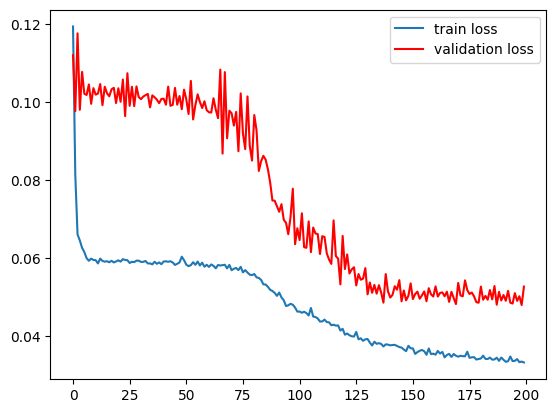

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses_train, label='train loss')
plt.plot(losses_valid, label='validation loss', color='r')
plt.legend()

plt.show()

In [14]:
model.eval()
with torch.no_grad():
    res = model(x_train[0:128].to(device)).cpu().detach()
    res = pd.DataFrame(res, columns=cols)

prediction = preproc.unprocess(res, bounds)
actual = preproc.unprocess(pd.DataFrame(y_train[0:128].numpy(), columns=cols), bounds)

display(prediction)
display(actual)

,latitude,longitude,timestamp
0,-14.956472,131.076531,1.565131e+09
1,-15.212038,131.101844,1.564859e+09
2,-14.889662,131.690436,1.564676e+09
3,-14.645594,131.571813,1.564631e+09
4,-14.165296,131.322979,1.564682e+09
...,...,...,...
123,-13.042846,132.065468,1.565745e+09
124,-12.764586,131.364718,1.565717e+09
125,-15.219019,131.549488,1.565518e+09
126,-14.760401,131.155064,1.565306e+09


,latitude,longitude,timestamp
0,-15.4381,130.5266,1.564662e+09
1,-15.1529,131.1778,1.564662e+09
2,-15.0855,130.5753,1.564662e+09
3,-14.3149,130.6678,1.564662e+09
4,-13.0290,132.9311,1.564662e+09
...,...,...,...
123,-12.7460,132.4806,1.565178e+09
124,-15.6436,130.5212,1.565212e+09
125,-15.3789,130.8517,1.565212e+09
126,-12.2964,131.1816,1.565212e+09


In [15]:
display(prediction.sort_values('timestamp'))
display(actual.sort_values('timestamp'))

,latitude,longitude,timestamp
22,-15.047789,131.539758,1.564619e+09
3,-14.645594,131.571813,1.564631e+09
21,-15.182929,131.488646,1.564674e+09
2,-14.889662,131.690436,1.564676e+09
4,-14.165296,131.322979,1.564682e+09
...,...,...,...
32,-15.129892,132.035895,1.565663e+09
29,-13.491508,132.149817,1.565685e+09
30,-13.376319,131.963505,1.565694e+09
124,-12.764586,131.364718,1.565717e+09


,latitude,longitude,timestamp
0,-15.4381,130.5266,1.564662e+09
1,-15.1529,131.1778,1.564662e+09
2,-15.0855,130.5753,1.564662e+09
3,-14.3149,130.6678,1.564662e+09
4,-13.0290,132.9311,1.564662e+09
...,...,...,...
123,-12.7460,132.4806,1.565178e+09
124,-15.6436,130.5212,1.565212e+09
125,-15.3789,130.8517,1.565212e+09
126,-12.2964,131.1816,1.565212e+09


In [16]:
display(prediction.std(axis=0))
display(actual.std(axis=0))

latitude          0.934592
longitude         0.647014
timestamp    254688.895514
dtype: float64

latitude          1.388009
longitude         1.676796
timestamp    169112.217511
dtype: float64

# Save the model's state_dict to a JSON file to evaluate later

In [17]:
model_path = "models/reduced_lstm.json"
model.to_json(model_path)

In [18]:
# load the model, just to be sure that we can
model.from_json(model_path)

In [19]:
model.eval()
with torch.no_grad():
    res = model(x_train[0:128].to(device)).cpu().detach()
    res = pd.DataFrame(res, columns=cols)

pred2 = preproc.unprocess(res, bounds)

In [20]:
display(prediction.sort_values('timestamp'))
display(pred2.sort_values('timestamp'))

,latitude,longitude,timestamp
22,-15.047789,131.539758,1.564619e+09
3,-14.645594,131.571813,1.564631e+09
21,-15.182929,131.488646,1.564674e+09
2,-14.889662,131.690436,1.564676e+09
4,-14.165296,131.322979,1.564682e+09
...,...,...,...
32,-15.129892,132.035895,1.565663e+09
29,-13.491508,132.149817,1.565685e+09
30,-13.376319,131.963505,1.565694e+09
124,-12.764586,131.364718,1.565717e+09


,latitude,longitude,timestamp
22,-15.047789,131.539758,1.564619e+09
3,-14.645594,131.571813,1.564631e+09
21,-15.182929,131.488646,1.564674e+09
2,-14.889662,131.690436,1.564676e+09
4,-14.165296,131.322979,1.564682e+09
...,...,...,...
32,-15.129892,132.035895,1.565663e+09
29,-13.491508,132.149817,1.565685e+09
30,-13.376319,131.963505,1.565694e+09
124,-12.764586,131.364718,1.565717e+09
